# Notebook 34: Multiplicity fractions

This notebook produces figures 5 and 6 of de Sá, Bernardo et al. (2024).

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.interpolate import interp1d

import sys
sys.path.append('..')
from src.zams import MultipleFraction, MassRatioDistribution, CompanionFrequencyDistribution

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [4]:
mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
scatter = False

## Reproducing multiple system fractions

The fundamental quantity that informs us about the fraction of multiple systems in general at different mass and period ranges is the **companion frequency distribution**,

$$f_{\log P;q\geq0.1}(M_1) = \frac{dN_\mathrm{comp}}{d\log P},$$

that is, the number of companions with $q\geq0.1$ per decade of orbital period for primaries with mass $M_1$. Because a primary can never have more than one companion with a given orbital period, it is always true that $f_{\log P;q\geq0.1}(M_1)\leq1$.

The **multiplicity frequency**, on the other hand, counts the companions at all frequencies and is defined as 

$$f_{\mathrm{mult};q\geq0.1}(M_1) = \int_{0.2}^8 d\log P\,f_{\log P;q\geq0.1}(M_1).$$

The multiplicity frequency measures the **average** number of companions for all primaries of mass $M_1$. It is thus possible for it to be greater than $1$, in which case the primaries have, on average, more than one companion. Note that neither of these quantities differentiate between binaries, triples, etc.

If we define $\mathcal{F}_{n;q\geq0.1}(M_1)$ as the **fraction of $M_1$ primaries with n companions**, then

$$f_{\mathrm{mult};q\geq0.1}(M_1) = \mathcal{F}_{n=1;q\geq0.1}(M_1) + 2\mathcal{F}_{n=2;q\geq0.1}(M_1) + 3\mathcal{F}_{n=3;q\geq0.1}(M_1) + \dots,$$

where $\mathcal{F}_{n=1;q\geq0.1}(M_1)$ is the **binary fraction**, $\mathcal{F}_{n=2;q\geq0.1}(M_1)$ the triple fraction, etc. The **single star fraction** is thus

$$\mathcal{F}_{n=0;q\geq0.1}(M_1) = 1 - \mathcal{F}_{n=1;q\geq0.1}(M_1) - \mathcal{F}_{n=2;q\geq0.1}(M_1) - \dots$$

It is thus not possible to directly obtain the binary fraction from the multiplicity frequency. In order to do so, an underlying distribution shape must be assumed. From Moe & di Stefano (2017), the number of companions $n$ of solar-type primaries has been observed to follow a Poisson distribution. We opt then to extrapolate this to *all* primaries. Thus, for any given mass, $n$ follows

$$P_{M_1}(n) = \frac{\lambda(M_1)^n}{n!}e^{-\lambda(M_1)},$$

where $\lambda(M_1)$ is the expectation value of $n$ at each $M_1$. A Poisson distributions describes the probability of $n$ events happening in a fixed interval if these events occur with a constant mean rate and indepently from the time since the last event (Wikipedia). In this case, we can interpret the Poissonian behavior of $n$ as meaning that the addition or formation of companions in a stellar systems occurs at a fixed mean rate *per primary* and independently from how many companions a primary already has (this seems unlikely, due to accretion). 

At any rate, we follow Moe & di Stefano (2017) in modelling the distribution of $n$ for each $M_1$ as a Poisson distribution truncated in the range $[0,3]$ and adjusting the expected values $\lambda(M_1)$ at each $M_1$ so that we reproduce the multiplicity frequency distribution obtained by integrating the observed companion frequency distribution over the period range.

In [6]:
def mult_freq(m1):
    q_distr = MassRatioDistribution()
    freq_distr = CompanionFrequencyDistribution(q_distr, m1)
    binfreq = quad(freq_distr.companion_frequency_q01, 0.2, 8, limit=1000)[0]
    return binfreq

In [7]:
mfreq_m1s = np.logspace(np.log10(0.8), np.log10(150), 10)
mfreqs = np.array([mult_freq(np.float32(m1)) for m1 in mfreq_m1s])

/tmp/ipykernel_41683/2941114795.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  binfreq = quad(freq_distr.companion_frequency_q01, 0.2, 8, limit=1000)[0]


Text(0.5, 1.0, 'Poissonians for different expectation values')

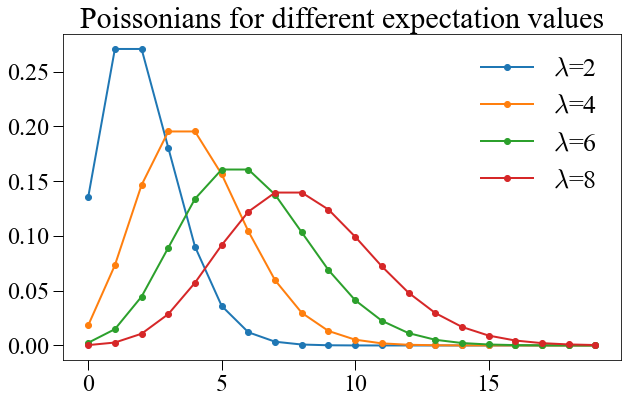

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

example_lamvdas = np.arange(0,10,2)[1:]
for lamvda in example_lamvdas:
    ax.plot(np.arange(0,20,1), poisson(lamvda).pmf(np.arange(0,20,1)), '-o', label=f'$\lambda$={lamvda}')
ax.legend(frameon=False)
ax.set_title('Poissonians for different expectation values')

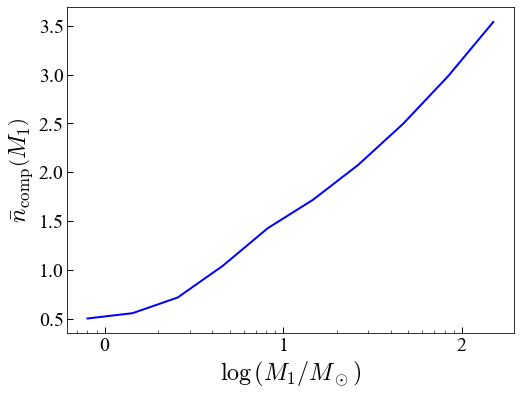

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mfreq_m1s, mfreqs, 'b-', lw=2)
ax.set_xscale('log')

ax.set_ylabel(r'$\bar{n}_\mathrm{comp}\left(M_1\right)$', fontsize=24)

ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.tick_params(axis='both', labelsize=20, length=6, direction='in')
ax.tick_params(axis='both', which='minor', length=3, direction='in')

In [10]:
ncomp_m1_ip = interp1d(mfreqs, mfreq_m1s)

In [11]:
m1_ncomp_ip = interp1d(mfreq_m1s, mfreqs)

In [12]:
ncp_mmax = []

Text(1.05, 0.25, '$m_1^\\mathrm{max} = 4.32\\,\\mathrm{M}_\\odot$')

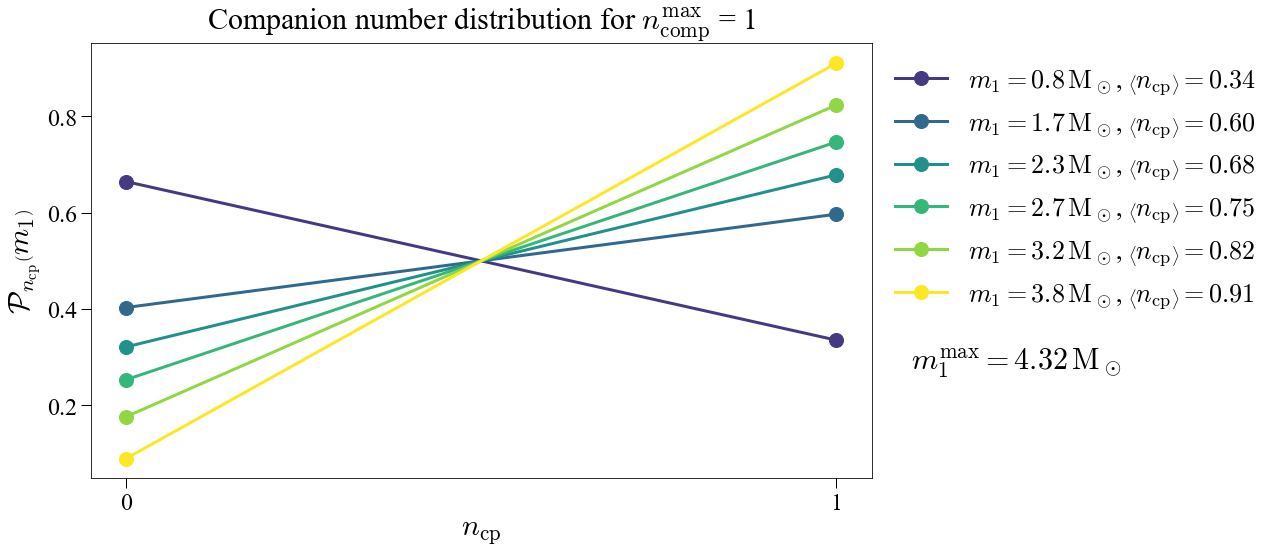

In [13]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 1
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

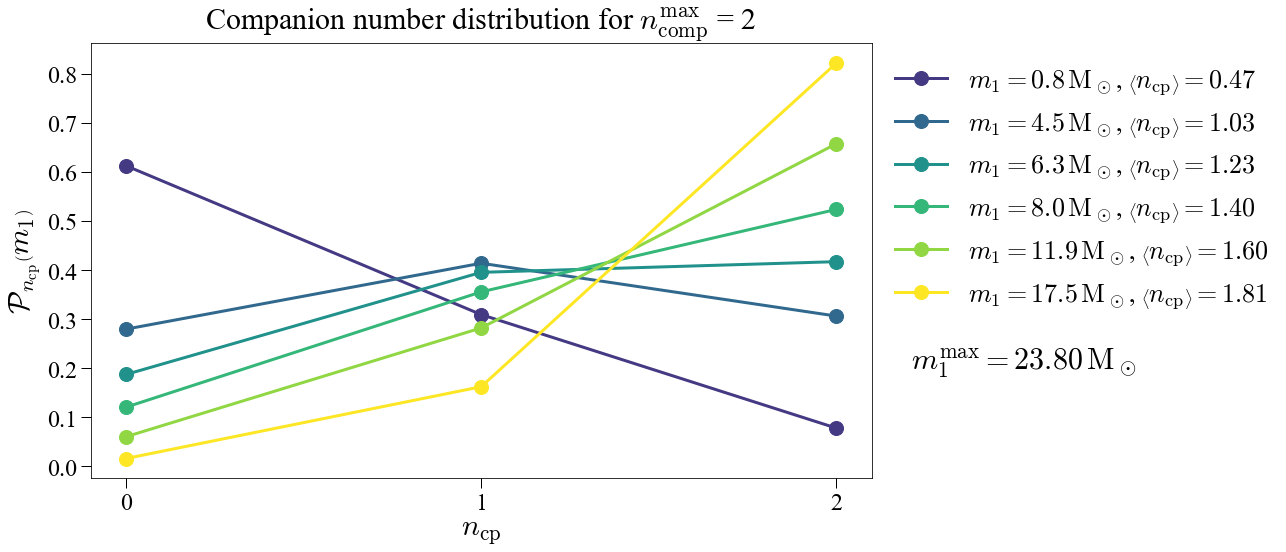

In [14]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 2
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax2.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax2.png', bbox_inches='tight')

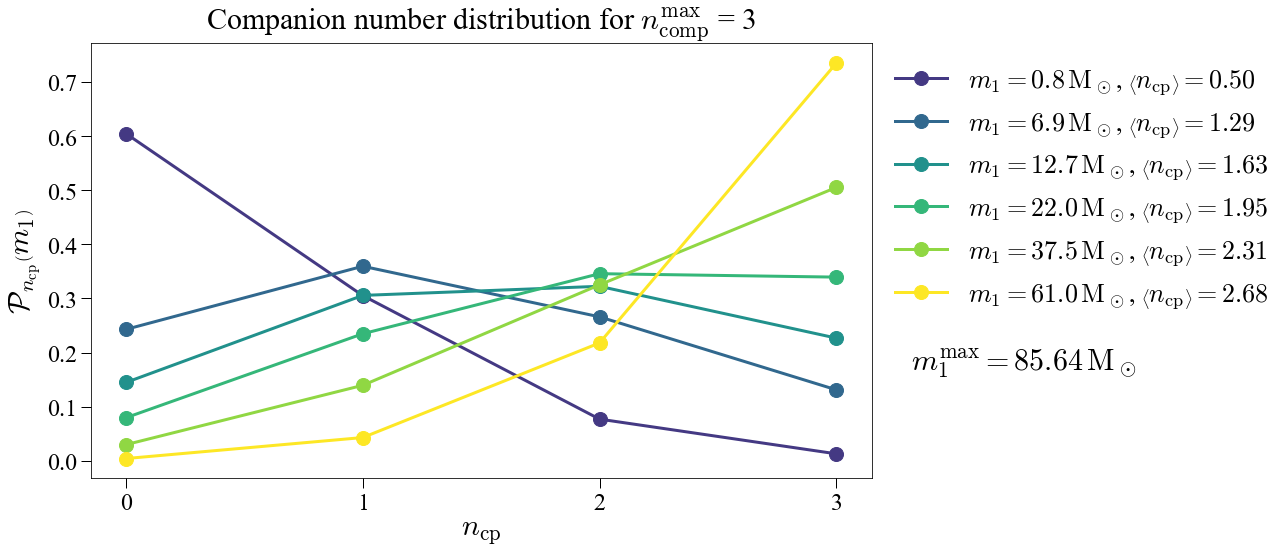

In [15]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 3
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax3.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax3.png', bbox_inches='tight')

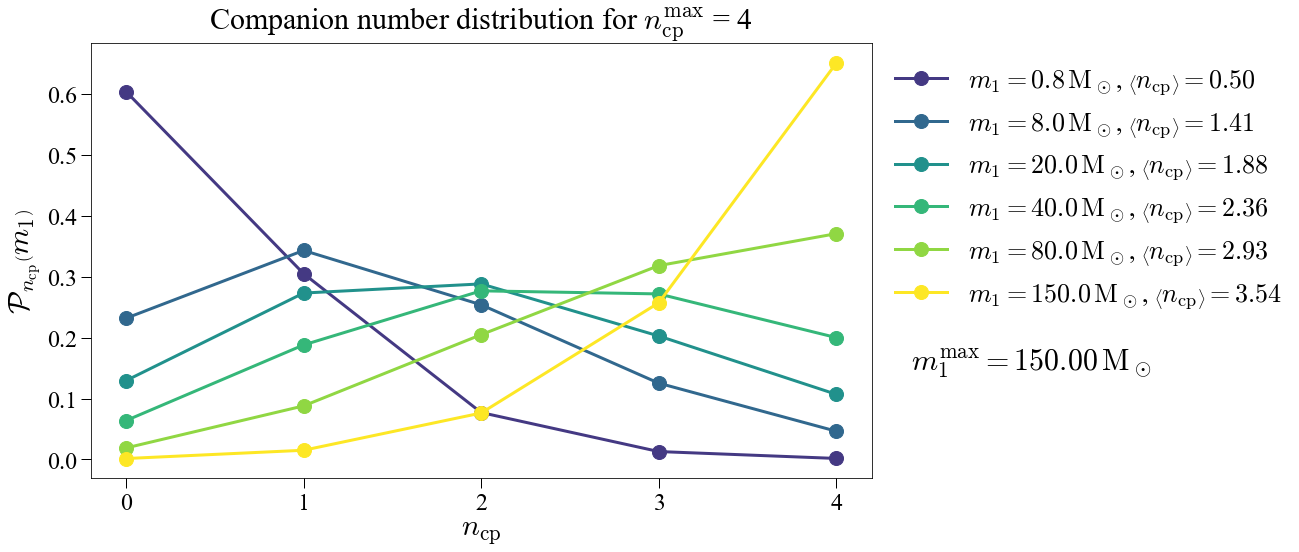

In [16]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 4
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
#ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{cp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax4.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax4.png', bbox_inches='tight')

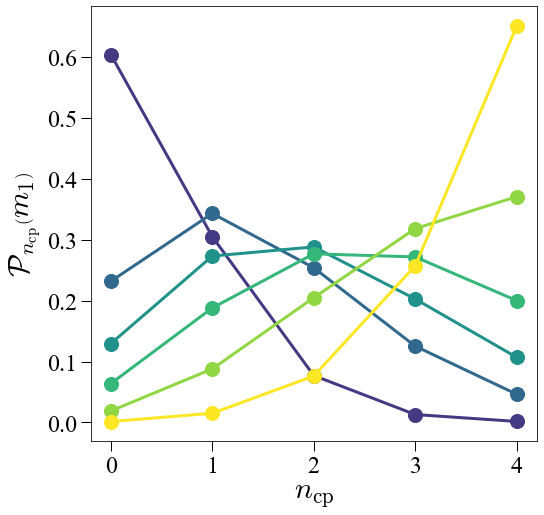

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
rect = fig.patch
rect.set_facecolor('white')

nmax = 4
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

#ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
#ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
#ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax4_mini.png', bbox_inches='tight')

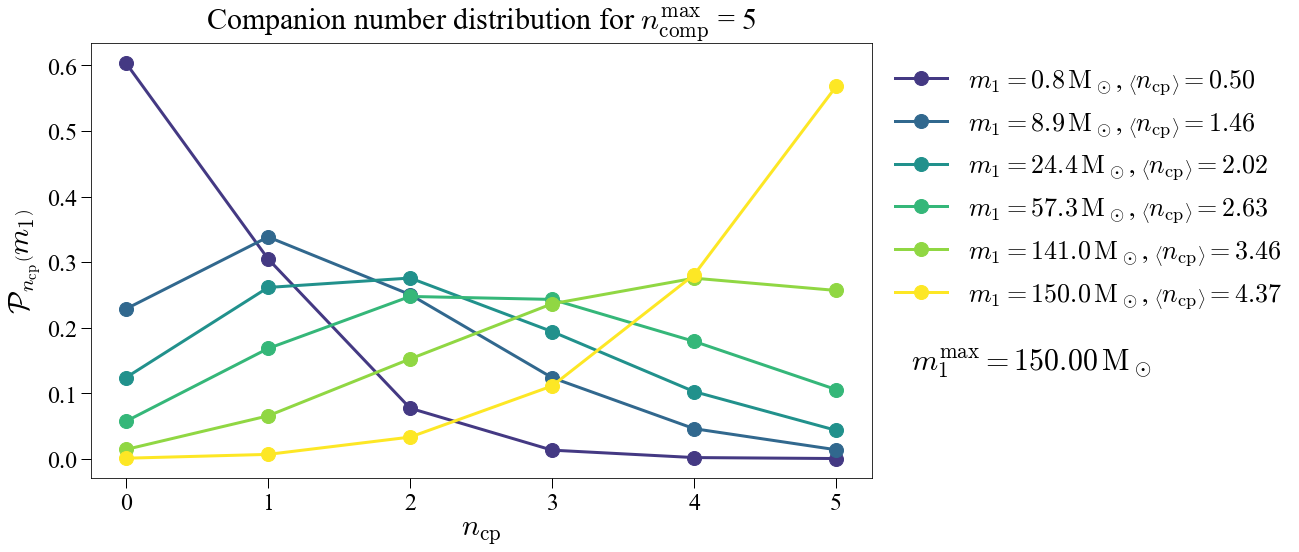

In [18]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 5
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax5.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax5.png', bbox_inches='tight')

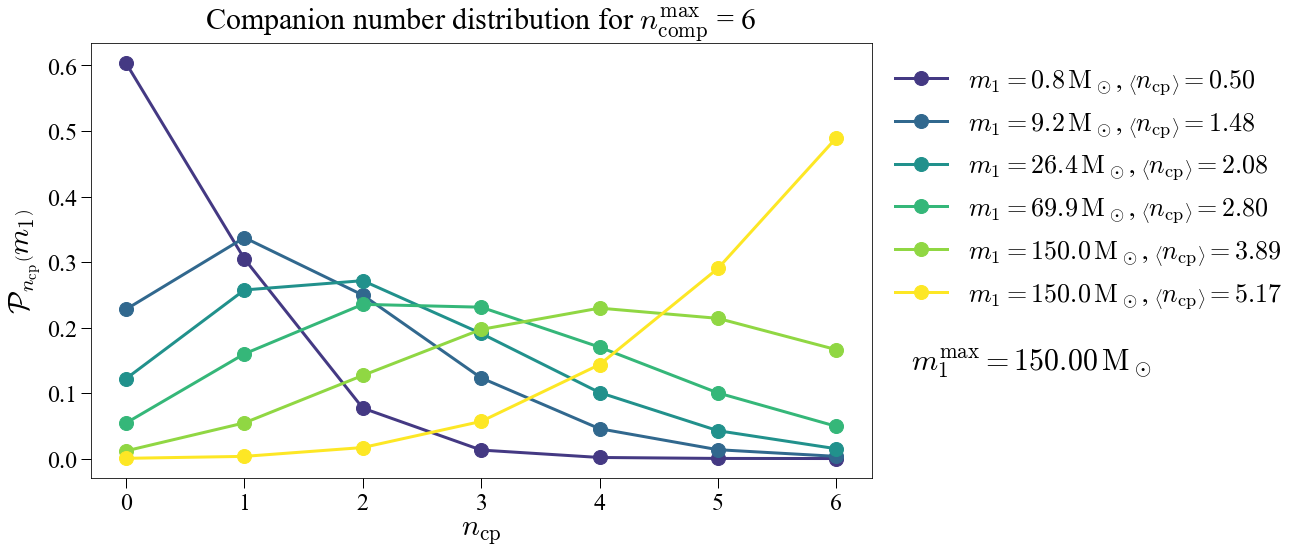

In [19]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 6
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax6.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax6.png', bbox_inches='tight')

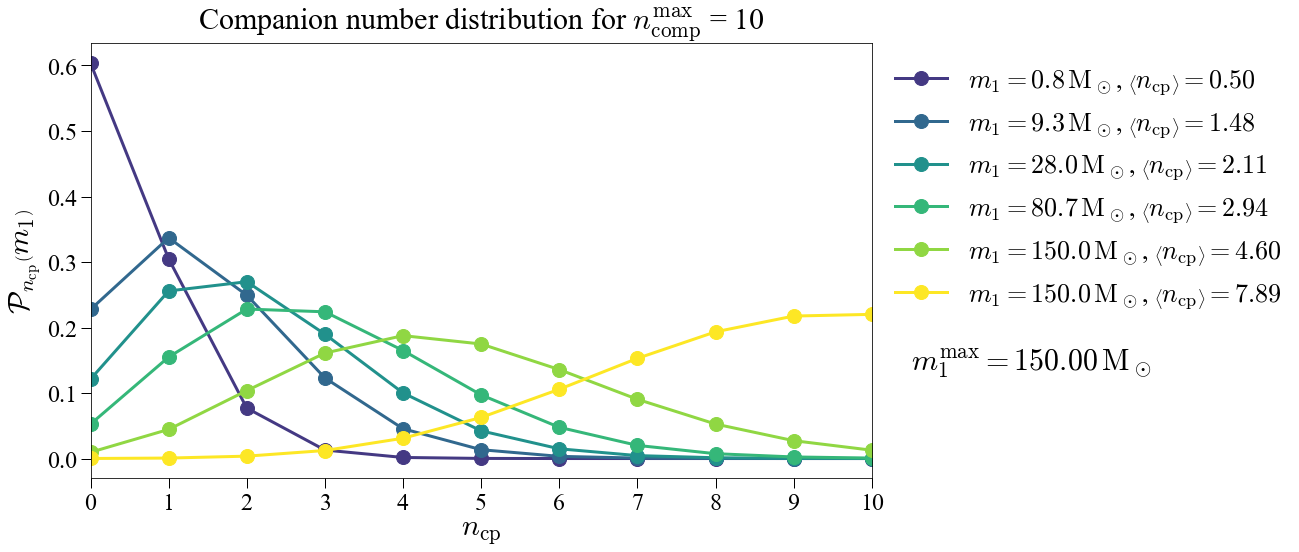

In [20]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 10
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

ax.set_xlim(0, 10)

plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax10.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'ncomp_prob_nmax10.png', bbox_inches='tight')

(-2.0, 20.0)

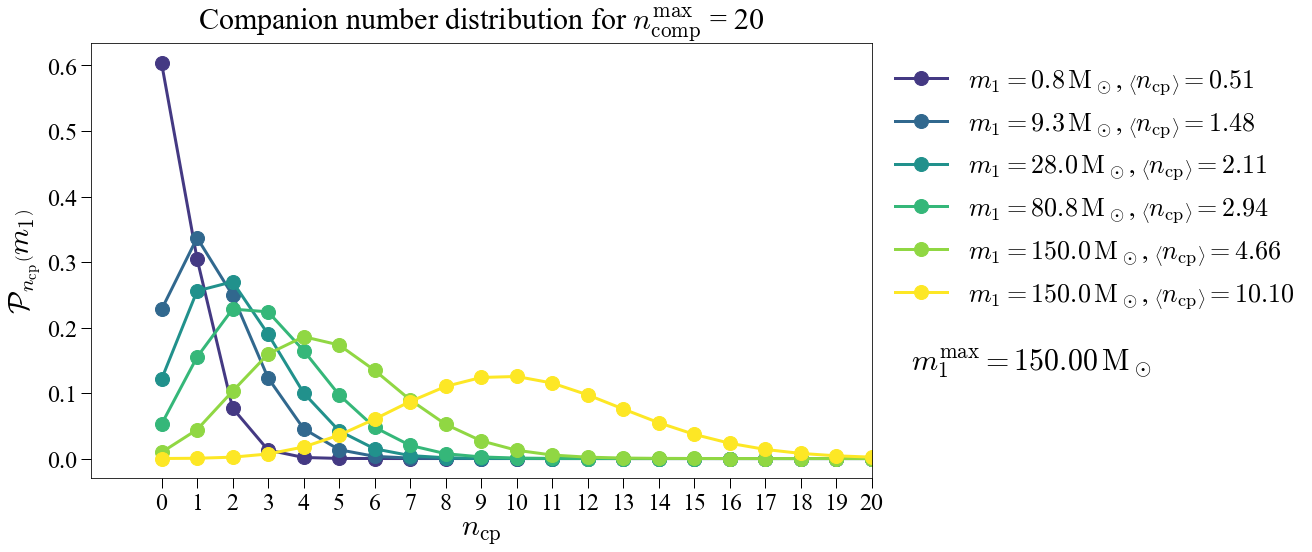

In [21]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 20
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
ncp_mmax.append([nmax, max_m1])

example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

ax.set_xlim(-2, 20)

(-2.0, 20.0)

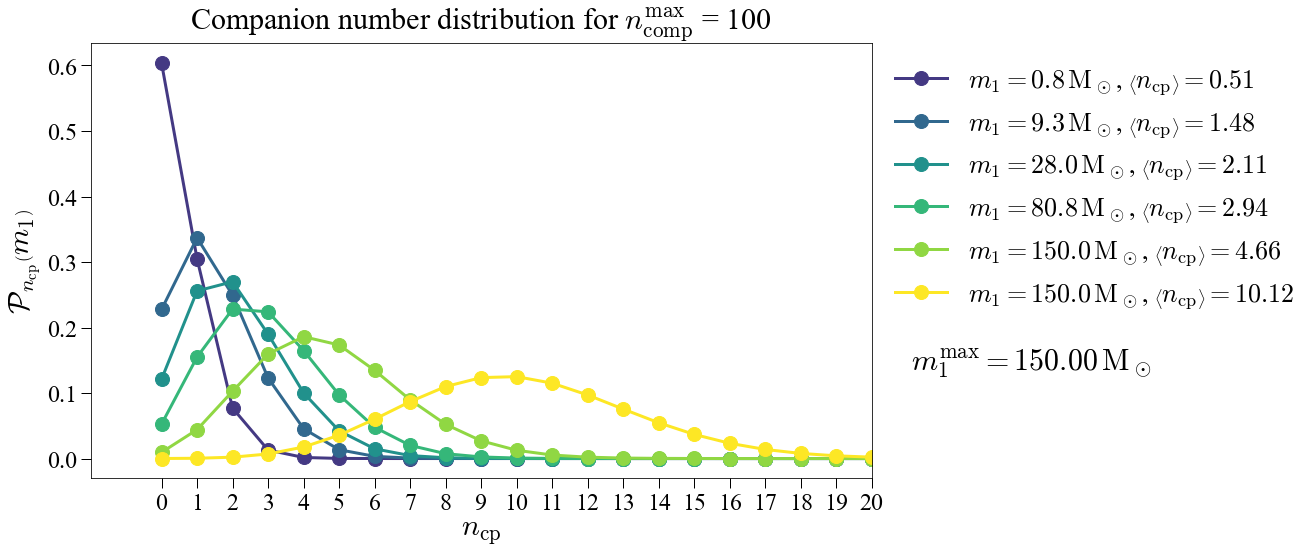

In [22]:
fig, ax = plt.subplots(figsize=(14,8))

nmax = 100
max_m1 = ncomp_m1_ip(min(mfreqs[-1], nmax))
example_lamvdas = [0.505, 1.48, 2.11, 2.945, 4.66, 10.12]
for i, lamvda in enumerate(example_lamvdas):
    c = cm.viridis((i+1)/len(example_lamvdas))
    ns = np.arange(0,nmax+1,1)
    ps = poisson(lamvda).pmf(ns)/np.sum(poisson(lamvda).pmf(ns))
    wmean = np.average(ns, weights=ps)
    mean_str = r'$m_1=%.1f\,\mathrm{M}_\odot$, $\left\langle n_\mathrm{cp}\right\rangle=%.2f$' %  \
    (ncomp_m1_ip(min(mfreqs[-1], max(mfreqs[0],wmean))), wmean)
    ax.plot(ns, ps, '-o', label=mean_str, c=c, lw=3, ms=14) 

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xlabel(r'$n_\mathrm{cp}$')
ax.set_xticks(np.arange(0, nmax+1, 1))
ax.set_ylabel(r'$\mathcal{P}_{n_\mathrm{cp}}\left(m_1\right)$')
ax.set_title(r'Companion number distribution for $n_\mathrm{comp}^\mathrm{max}$ = %.0f' % nmax)

m1max_str = r'$m_1^\mathrm{max} = %.2f\,\mathrm{M}_\odot$' % max_m1
ax.text(1.05, 0.25, m1max_str, transform=ax.transAxes)

ax.set_xlim(-2, 20)

In [23]:
ncp_mmax = np.array(ncp_mmax)[:4]

In [24]:
ncp_mmax.T

array([[  1.        ,   2.        ,   3.        ,   5.        ],
       [  4.31713627,  23.79765234,  85.64013694, 150.        ]])

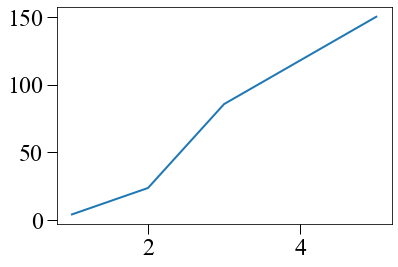

In [25]:

plt.plot(*ncp_mmax.T)

In [26]:
class MultipleFraction_Quint_ip:
    
    def __init__(self, m1_array, nmax=3):
        self.q_distr = MassRatioDistribution()
        self.m1_array = m1_array
        self.lamvda_array = np.zeros(self.m1_array.shape)
        self.binary_fraction = np.zeros(self.lamvda_array.shape)
        self.ip_fmult_to_lambda = None
        self.nmax = nmax
          
    def fmult_l(self, l):
        summ = 0
        for n in range(self.nmax):
            summ += l**n / np.math.factorial(n)
        num = l**self.nmax / np.math.factorial(self.nmax)
        return l / (1 + num / summ)
    
    def set_ip_fmult(self):
        ls = np.linspace(0, 20, 100)
        fmults = np.array([self.fmult_l(l) for l in ls])
        self.ip_fmult_to_lambda = interp1d(fmults, ls)
            
    def get_mult_freq(self, m1):
        freq_distr = CompanionFrequencyDistribution(self.q_distr, m1)
        multfreq = quad(freq_distr.companion_frequency_q01, 0.2, 8, limit=1000)[0]
        return multfreq
       
    def solve_m1(self, m1, guess=1):
        m1_mult_freq = self.get_mult_freq(m1)
        lamvda = self.ip_fmult_to_lambda(m1_mult_freq)
        return lamvda
    
    def solve(self):
        guess = 0
        for i, m1 in enumerate(self.m1_array):
            time0 = time()
            try:
                lamvda = self.solve_m1(m1, guess)
            except:
                self.m1_array = self.m1_array[:i]
                self.lamvda_array = self.lamvda_array[:i]
                self.binary_fraction = self.binary_fraction[:i]
                break
            else:
                self.lamvda_array[i] = lamvda
                time1 = time() - time0
                print(f'Found lambda = {lamvda} for M1 = {m1} in {time1:.4f} s.')
        self.m1_array = self.m1_array[:i+1]
        self.lamvda_array = self.lamvda_array[:i+1]
        self.binary_fraction = self.binary_fraction[:i+1]
    
    def poisson_mdf(self, l, k):
        norm = np.sum(poisson(l).pmf(np.arange(0, self.nmax+1, 1)))
        return poisson(l).pmf(k)/norm
    
    def multiple_fraction(self, n):
        fracs = np.zeros(self.lamvda_array.shape)
        for i, lamvda in enumerate(self.lamvda_array):
            frac = self.poisson_mdf(lamvda, n)
            fracs[i] = frac
        fracs = np.array(fracs)
        return fracs
    
    def get_binary_fraction(self):
        for i, lamvda in enumerate(self.lamvda_array):
            fracs = [self.poisson_mdf(lamvda, n) for n in np.arange(1, self.nmax+1, 1)]
            den = fracs[0]
            for n, frac in list(enumerate(fracs))[1:]:
                den += n*frac
            self.binary_fraction[i] = np.sum(fracs[1:]) / den
        return self.binary_fraction

In [5]:
nmax = 1
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 8.4147 s.


array([0.8       , 0.86784341, 0.94144022, 1.02127836, 1.10788711,
       1.20184065, 1.30376186, 1.41432641, 1.53426731, 1.66437971,
       1.8055262 , 1.95864251, 2.12474373, 2.30493104, 2.50039901,
       2.71244348, 2.94247024, 3.19200424, 3.46269979, 3.75635147])

In [6]:
m1array1 = [0.8       , 0.86784341, 0.94144022, 1.02127836, 1.10788711,
       1.20184065, 1.30376186, 1.41432641, 1.53426731, 1.66437971,
       1.8055262 , 1.95864251, 2.12474373, 2.30493104, 2.50039901,
       2.71244348, 2.94247024, 3.19200424, 3.46269979, 3.75635147]

In [7]:
nmax1_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax1_fracs.append(fracs)
binary1_fraction  = multiplefrac.binary_fraction

In [8]:
nmax = 2
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 7.8139 s.


array([ 0.8       ,  0.94111684,  1.10712613,  1.30241881,  1.53216034,
        1.80242738,  2.12036844,  2.49439306,  2.93439414,  3.45200968,
        4.06093055,  4.77726266,  5.61995292,  6.61129042,  7.77749593,
        9.1494155 , 10.76333625, 12.66194625, 14.89546355, 17.52296448])

In [9]:
m1array2 = [0.8       ,  0.94111684,  1.10712613,  1.30241881,  1.53216034,
        1.80242738,  2.12036844,  2.49439306,  2.93439414,  3.45200968,
        4.06093055,  4.77726266,  5.61995292,  6.61129042,  7.77749593,
        9.1494155 , 10.76333625, 12.66194625, 14.89546355, 17.52296448]

In [10]:
nmax2_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax2_fracs.append(fracs)
binary2_fraction  = multiplefrac.binary_fraction

In [11]:
nmax = 3
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 7.2049 s.


array([ 0.8       ,  1.00497316,  1.26246382,  1.58592783,  1.99226863,
        2.50272064,  3.14395884,  3.94949283,  4.96141788,  6.23261477,
        7.82951323,  9.83556335, 12.35559651, 15.52130364, 19.49811702,
       24.49385542, 30.76958421, 38.65325797, 48.55685866, 60.9979248 ])

In [12]:
m1array3 = [ 0.8       ,  1.00497316,  1.26246382,  1.58592783,  1.99226863,
        2.50272064,  3.14395884,  3.94949283,  4.96141788,  6.23261477,
        7.82951323,  9.83556335, 12.35559651, 15.52130364, 19.49811702,
       24.49385542, 30.76958421, 38.65325797, 48.55685866, 60.9979248 ]

In [13]:
nmax3_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax3_fracs.append(fracs)
binary3_fraction  = multiplefrac.binary_fraction

In [14]:
nmax = 4
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 6.9842 s.


array([  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ])

In [15]:
m1array4gtr = [  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ]

In [16]:
nmax4_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax4_fracs.append(fracs)
binary4_fraction  = multiplefrac.binary_fraction

Each `nmax` defines a maximum `m1` which must be found by minimizing a given function computed from the period distributions; because for high `nmax` this maximum is over $150\,\mathrm{M}_\odot$, the minimizer jumps outside of the boundaries of the period distributions, generating RuntimeWarnings. These are no reason to concern because in those cases the maximum is set to $150$.

In [17]:
nmax = 5
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 6.8712 s.


array([  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ])

In [18]:
nmax5_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax5_fracs.append(fracs)
binary5_fraction  = multiplefrac.binary_fraction

In [19]:
nmax = 7
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 7.0038 s.


array([  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ])

In [20]:
nmax7_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax7_fracs.append(fracs)
binary7_fraction  = multiplefrac.binary_fraction

In [21]:
nmax = 10
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 6.8698 s.


array([  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ])

In [22]:
nmax10_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax10_fracs.append(fracs)
binary10_fraction  = multiplefrac.binary_fraction

In [23]:
nmax = 100
multiplefrac = MultipleFraction(nmax=nmax)
multiplefrac.solve()
multiplefrac.m1_array

Setting up M1 to companion Nmean interpolator...
Done setting up interpolator. Elapsed time: 6.9980 s.


array([  0.8       ,   1.05371129,   1.38788435,   1.82803676,
         2.40777871,   3.17137951,   4.17714799,   5.501885  ,
         7.24674791,   9.54497511,  12.57206003,  16.55915197,
        21.81070671,  28.72773485,  37.83842314,  49.83846703,
        65.64419416,  86.46253555, 113.88318723, 150.        ])

In [24]:
nmax100_fracs = []
for n in np.arange(0, nmax+1, 1):
    n = np.array([n]).flatten()
    fracs = multiplefrac.get_multiple_fraction(n)
    nmax100_fracs.append(fracs)
binary100_fraction  = multiplefrac.binary_fraction

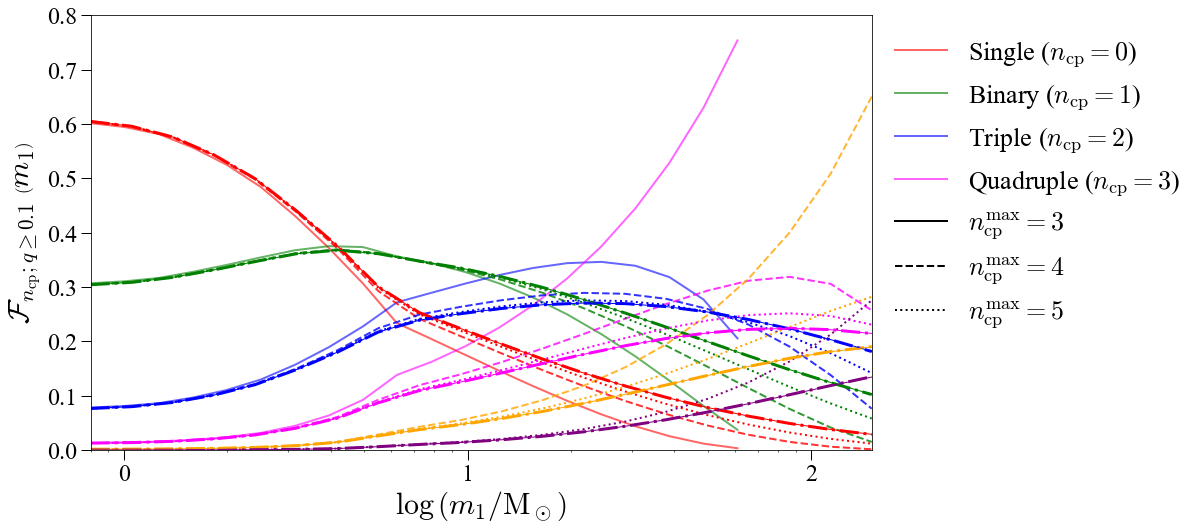

In [70]:
fig, ax = plt.subplots(figsize=(14,8))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple', 6 : 'cyan', 7 : 'navy'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

for n, fracs in enumerate(nmax3_fracs):
    ax.plot(m1array3, fracs, alpha=0.6, ls='-', label=label_dict[n], lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(m1array4gtr, fracs, alpha=0.8, ls='--', lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax5_fracs):
    ax.plot(m1array4gtr, fracs, alpha=1, ls=':', lw=2, color=color_dict[n])

for n, fracs in enumerate(nmax10_fracs[:6]):
    ax.plot(m1array4gtr, fracs, alpha=1, ls='-.', lw=3, color=color_dict[n])

for n, fracs in enumerate(nmax100_fracs[:6]):
    ax.plot(m1array4gtr, fracs, alpha=1, ls='-', lw=1, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n_\mathrm{cp};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0, 0.8)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.png', bbox_inches='tight')

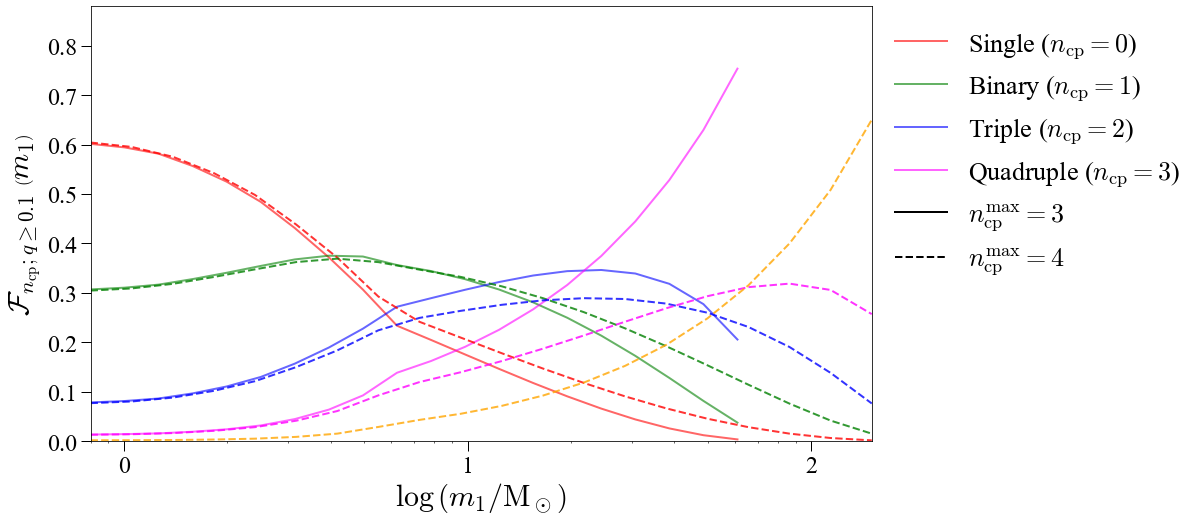

In [46]:
fig, ax = plt.subplots(figsize=(14,8))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

for n, fracs in enumerate(nmax3_fracs):
    ax.plot(m1array3, fracs, alpha=0.6, ls='-', label=label_dict[n], lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(m1array4gtr, fracs, alpha=0.8, ls='--', lw=2, color=color_dict[n])
        
#for n, fracs in enumerate(nmax5_fracs):
#    ax.plot(m1array4gtr, fracs, alpha=1, ls=':', lw=2, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n_\mathrm{cp};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0, 0.88)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.png', bbox_inches='tight')

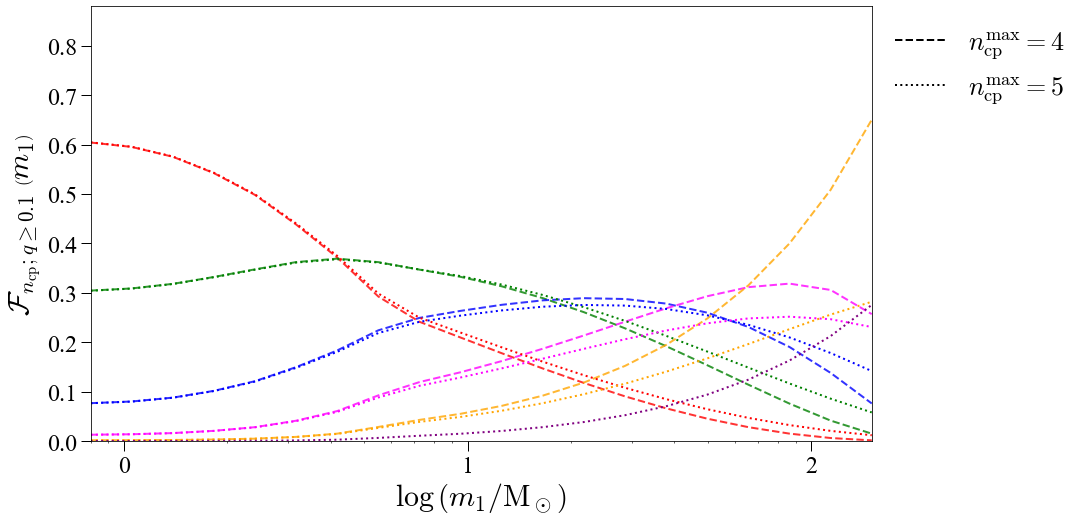

In [47]:
fig, ax = plt.subplots(figsize=(14,8))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

#for n, fracs in enumerate(nmax3_fracs):
#    ax.plot(m1array3, fracs, alpha=0.6, ls='-', label=label_dict[n], lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(m1array4gtr, fracs, alpha=0.8, ls='--', lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax5_fracs):
    ax.plot(m1array4gtr, fracs, alpha=1, ls=':', lw=2, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
#ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n_\mathrm{cp};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0, 0.88)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'nmaxcomp_choice.png', bbox_inches='tight')

In [48]:
def salpeter(m1):
    return m1**-2.3

In [49]:
salpeter(150)

9.885305697564042e-06

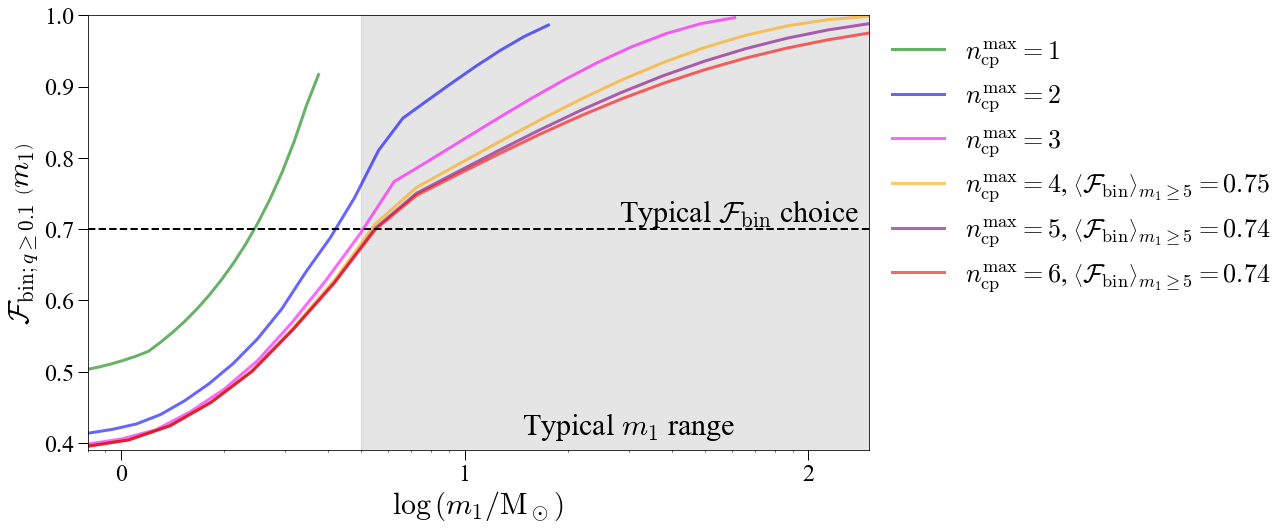

In [50]:
fig, ax = plt.subplots(figsize=(14,8))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple', 6 : 'red'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

#for n, fracs in enumerate(nmax3_fracs):

mean_fbins = np.zeros(3)
norm = 0
for m1, fbin4, fbin5, fbin7 in zip(m1array4gtr, np.sum(nmax4_fracs[1:], axis=0), np.sum(nmax5_fracs[1:], axis=0), np.sum(nmax7_fracs[1:], axis=0)):
    if m1 >= 5:
        imf = salpeter(m1)
        norm += imf
        mean_fbins[0] += imf*fbin4
        mean_fbins[1] += imf*fbin5
        mean_fbins[2] += imf*fbin7
mean_fbins /= norm

ax.plot(m1array1, np.sum(nmax1_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[1], label=r'$n_\mathrm{cp}^\mathrm{max}=1$')
ax.plot(m1array2, np.sum(nmax2_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[2], label=r'$n_\mathrm{cp}^\mathrm{max}=2$')
ax.plot(m1array3, np.sum(nmax3_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[3], label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot(m1array4gtr, np.sum(nmax4_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[4], label=r'$n_\mathrm{cp}^\mathrm{max}=4$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[0])
ax.plot(m1array4gtr, np.sum(nmax5_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[5], label=r'$n_\mathrm{cp}^\mathrm{max}=5$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[1])
ax.plot(m1array4gtr, np.sum(nmax7_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[6], label=r'$n_\mathrm{cp}^\mathrm{max}=6$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[2])
        
#for n, fracs in enumerate(nmax4_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.8, ls='--', lw=2, color=color_dict[n])
        
#for n, fracs in enumerate(nmax5_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], ls='-', lw=2, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
#ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
#ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.axvspan(5, 150, color='k', alpha=0.1)
ax.text(30, 0.4, 'Typical $m_1$ range', va='bottom', ha='center')
ax.hlines(0.7, 0.8, 150, color='k', ls='--', lw=2)
ax.text(140, 0.7, 'Typical $\mathcal{F}_\mathrm{bin}$ choice', va='bottom', ha='right')

ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{\mathrm{bin};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0.39, 1)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'onlybin_binfrac.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'onlybin_binfrac.png', bbox_inches='tight')

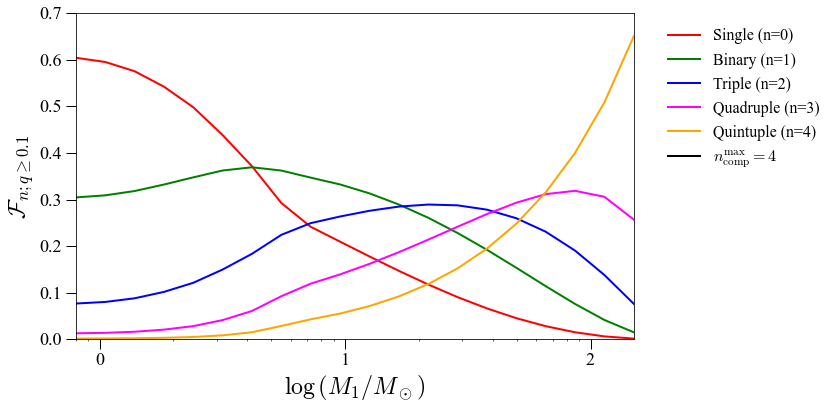

In [51]:
fig, ax = plt.subplots(figsize=(10,6))
label_dict = {0 : 'Single (n=0)', 1 : 'Binary (n=1)', 2 : 'Triple (n=2)', 3 : 'Quadruple (n=3)', 4 : 'Quintuple (n=4)', 5 : 'Sextuple (n=5)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

#for n, fracs in enumerate(nmax3_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.6, ls='--', lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], ls='-', lw=2, color=color_dict[n])
        
#for n, fracs in enumerate(nmax5_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], ls='-', lw=3, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
#ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=4$')
#ax.plot([-2, -1], [0, 0], 'k-', lw=3, label=r'$n_\mathrm{comp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.legend(loc=(1.05, 0.5), fontsize=16, frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n;q\geq0.1}$', fontsize=24)
ax.set_ylim(0, 0.7)

ax.tick_params(axis='both', labelsize=18)

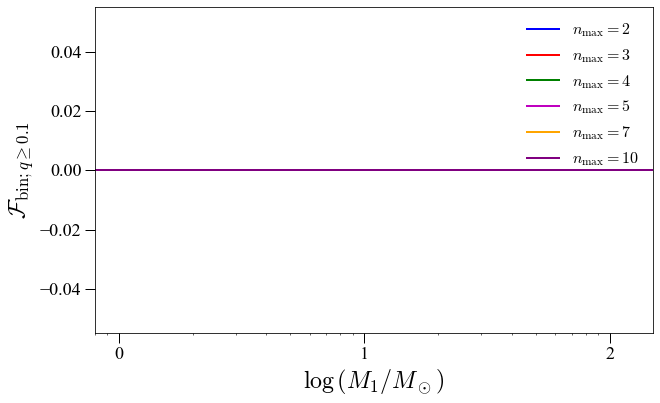

In [52]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(multiplefrac.m1_array[:len(binary2_fraction)], binary2_fraction, 'b-', lw=2, label=f'$n_\mathrm{{max}}={2}$')
ax.plot(multiplefrac.m1_array[:len(binary3_fraction)], binary3_fraction, 'r-', lw=2, label=f'$n_\mathrm{{max}}={3}$')
ax.plot(multiplefrac.m1_array[:len(binary4_fraction)], binary4_fraction, 'g-', lw=2, label=f'$n_\mathrm{{max}}={4}$')
ax.plot(multiplefrac.m1_array[:len(binary5_fraction)], binary5_fraction, 'm-', lw=2, label=f'$n_\mathrm{{max}}={5}$')
ax.plot(multiplefrac.m1_array[:len(binary7_fraction)], binary7_fraction, c='orange', ls='-', lw=2, label=f'$n_\mathrm{{max}}={7}$')
ax.plot(multiplefrac.m1_array[:len(binary10_fraction)], binary10_fraction, c='purple', ls='-', lw=2, label=f'$n_\mathrm{{max}}={10}$')
ax.legend(fontsize=16, frameon=False)


ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{\mathrm{bin};q\geq0.1}$', fontsize=24)
#ax.set_ylim(0, 1)

ax.tick_params(axis='both', labelsize=18)
ax.legend(fontsize=16, frameon=False)

In [53]:
binary_fraction = binary3_fraction

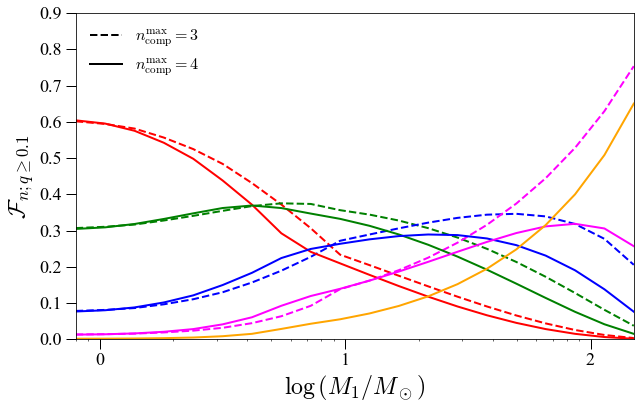

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
label_dict = {0 : 'Single (n=0)', 1 : 'Binary (n=1)', 2 : 'Triple (n=2)', 3 : 'Quadruple (n=3)', 4 : 'Quintuple (n=4)', 5 : 'Sextuple (n=5)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

for n, fracs in enumerate(nmax3_fracs):
    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, ls='--', lw=2, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, ls='-', lw=2, color=color_dict[n])
        
#for n, fracs in enumerate(nmax5_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], ls='-', lw=3, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=4$')
#ax.plot([-2, -1], [0, 0], 'k-', lw=3, label=r'$n_\mathrm{comp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.legend(loc='upper left', fontsize=16, frameon=False)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n;q\geq0.1}$', fontsize=24)
ax.set_ylim(0, 0.9)

ax.tick_params(axis='both', labelsize=18)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


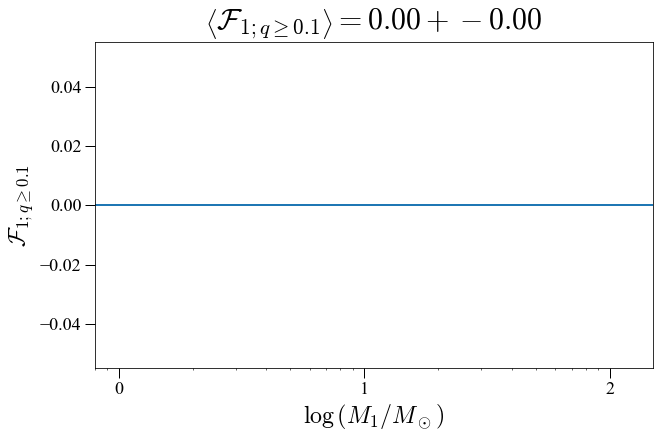

In [55]:
fig, ax = plt.subplots(figsize=(10,6))
label_dict = {0 : 'Single (n=0)', 1 : 'Binary (n=1)', 2 : 'Triple (n=2)', 3 : 'Quadruple (n=3)'}

ax.plot(multiplefrac.m1_array, binary_fraction, '-', lw=2)
ax.legend(fontsize=16, frameon=False)
ax.set_title(r'$\left\langle\mathcal{F}_{1;q\geq0.1}\right\rangle=%.2f +- %.2f$' % (np.mean(binary_fraction), np.std(binary_fraction)))

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{1;q\geq0.1}$', fontsize=24)
#ax.set_ylim(0, 1.1)

ax.tick_params(axis='both', labelsize=18)

In [56]:
binfrac_interp = interp1d(multiplefrac.m1_array, binary_fraction)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


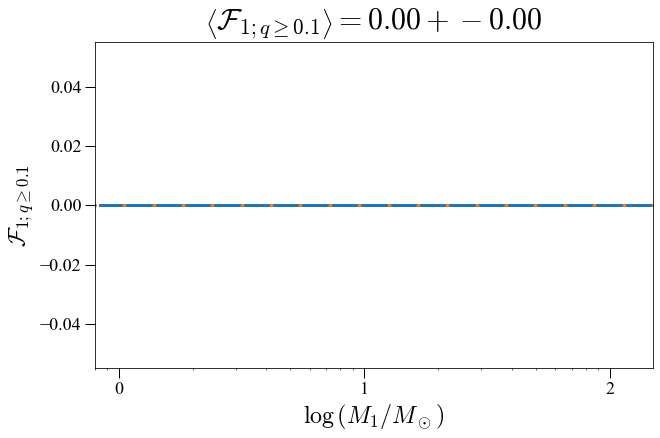

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
label_dict = {0 : 'Single (n=0)', 1 : 'Binary (n=1)', 2 : 'Triple (n=2)', 3 : 'Quadruple (n=3)'}

ax.plot(np.logspace(np.log10(0.84), np.log10(149), 1000), binfrac_interp(np.logspace(np.log10(0.84), np.log10(149), 1000)), '-', lw=3)
ax.plot(multiplefrac.m1_array, binary_fraction, '.', ms=5)
ax.legend(fontsize=16, frameon=False)
ax.set_title(r'$\left\langle\mathcal{F}_{1;q\geq0.1}\right\rangle=%.2f +- %.2f$' % (np.mean(binary_fraction), np.std(binary_fraction)))

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(M_1/M_\odot\right)$', fontsize=24)
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{1;q\geq0.1}$', fontsize=24)
#ax.set_ylim(0, 1.1)

ax.tick_params(axis='both', labelsize=18)

In [58]:
binfrac_dict = {}
for m1, binfrac in zip(table_m1s, binary_fraction):
    binfrac_dict[m1] = binfrac

NameError: name 'table_m1s' is not defined

## Square plots

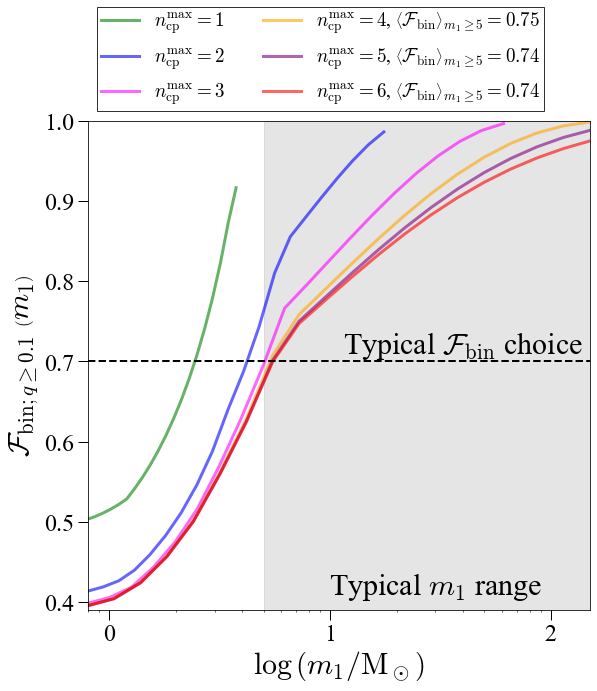

In [59]:
fig, ax = plt.subplots(figsize=(9,9))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple', 6 : 'red'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

#for n, fracs in enumerate(nmax3_fracs):

mean_fbins = np.zeros(3)
norm = 0
for m1, fbin4, fbin5, fbin7 in zip(m1array4gtr, np.sum(nmax4_fracs[1:], axis=0), np.sum(nmax5_fracs[1:], axis=0), np.sum(nmax7_fracs[1:], axis=0)):
    if m1 >= 5:
        imf = salpeter(m1)
        norm += imf
        mean_fbins[0] += imf*fbin4
        mean_fbins[1] += imf*fbin5
        mean_fbins[2] += imf*fbin7
mean_fbins /= norm

ax.plot(m1array1, np.sum(nmax1_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[1], label=r'$n_\mathrm{cp}^\mathrm{max}=1$')
ax.plot(m1array2, np.sum(nmax2_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[2], label=r'$n_\mathrm{cp}^\mathrm{max}=2$')
ax.plot(m1array3, np.sum(nmax3_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[3], label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot(m1array4gtr, np.sum(nmax4_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[4], label=r'$n_\mathrm{cp}^\mathrm{max}=4$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[0])
ax.plot(m1array4gtr, np.sum(nmax5_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[5], label=r'$n_\mathrm{cp}^\mathrm{max}=5$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[1])
ax.plot(m1array4gtr, np.sum(nmax7_fracs[1:], axis=0), alpha=0.6, ls='-', lw=3, color=color_dict[6], label=r'$n_\mathrm{cp}^\mathrm{max}=6$, $\left\langle\mathcal{F}_\mathrm{bin}\right\rangle_{m_1\geq5}=%.2f$' % mean_fbins[2])
        
#for n, fracs in enumerate(nmax4_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.8, ls='--', lw=2, color=color_dict[n])
        
#for n, fracs in enumerate(nmax5_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], ls='-', lw=2, color=color_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
#ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
#ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

ax.axvspan(5, 150, color='k', alpha=0.1)
ax.text(30, 0.4, 'Typical $m_1$ range', va='bottom', ha='center')
ax.hlines(0.7, 0.8, 150, color='k', ls='--', lw=2)
ax.text(140, 0.7, 'Typical $\mathcal{F}_\mathrm{bin}$ choice', va='bottom', ha='right')

#ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax.legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1), ncol=2, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=19)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{\mathrm{bin};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0.39, 1)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'square_onlybin_binfrac.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'square_onlybin_binfrac.png', bbox_inches='tight')

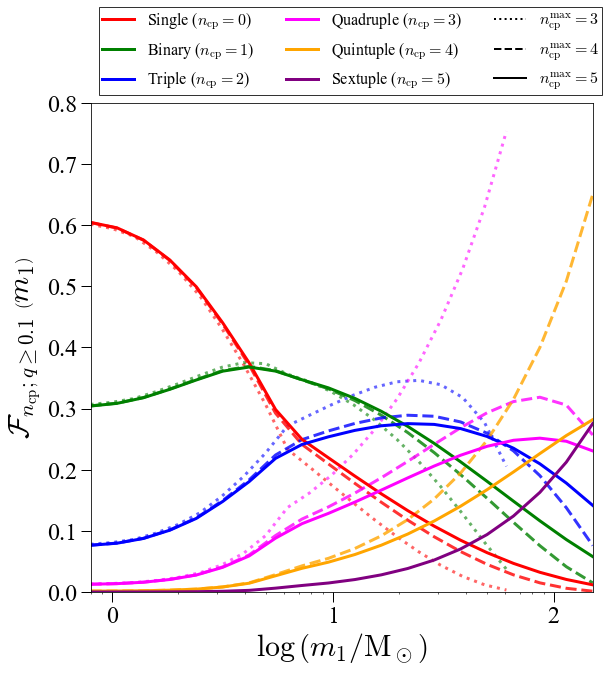

In [25]:
fig, ax = plt.subplots(figsize=(9,9))
label_dict = {0 : 'Single ($n_\mathrm{cp}=0$)', 1 : 'Binary ($n_\mathrm{cp}=1$)', 2 : 'Triple ($n_\mathrm{cp}=2$)', 3 : 'Quadruple ($n_\mathrm{cp}=3$)', 4 : 'Quintuple ($n_\mathrm{cp}=4$)', 5 : 'Sextuple ($n_\mathrm{cp}=5$)'}
color_dict = {0 : 'red', 1 : 'green', 2 : 'blue', 3 : 'magenta', 4 : 'orange', 5 : 'purple'}
nmax_list = [2, 3, 4, 5]
             
#for n, fracs in enumerate(nmax2_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=0.4, ls=':', lw=2, color=color_dict[n])

for n, fracs in enumerate(nmax3_fracs):
    ax.plot(m1array3, fracs, alpha=0.6, ls=':', lw=3, color=color_dict[n])
        
for n, fracs in enumerate(nmax4_fracs):
    ax.plot(m1array4gtr, fracs, alpha=0.8, ls='--', lw=3, color=color_dict[n])
        
for n, fracs in enumerate(nmax5_fracs):
    ax.plot(m1array4gtr, fracs, alpha=1, ls='-', lw=3, color=color_dict[n], label=label_dict[n])

#ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{comp}^\mathrm{max}=2$')
ax.plot([-2, -1], [0, 0], 'k:', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=3$')
ax.plot([-2, -1], [0, 0], 'k--', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=4$')
ax.plot([-2, -1], [0, 0], 'k-', lw=2, label=r'$n_\mathrm{cp}^\mathrm{max}=5$')
      
    
#for n, fracs in enumerate(nmax7_fracs):
#    ax.plot(multiplefrac.m1_array[:len(fracs)], fracs, alpha=1, label=label_dict[n], lw=2, color=color_dict[n])

#ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax.legend(frameon=True, loc='lower left', bbox_to_anchor=(0,1), ncol=3, edgecolor='black', fancybox=False, borderpad=0.2, fontsize=16)

ax.set_xscale('log')
ax.set_xlabel(r'$\log\left(m_1/\mathrm{M}_\odot\right)$')
ax.set_xlim(0.8, 150)
ax.set_xticks([1, 10, 100])
ax.set_xticklabels([0, 1, 2])

ax.set_ylabel(r'$\mathcal{F}_{n_\mathrm{cp};q\geq0.1}\;\left(m_1\right)$')
ax.set_ylim(0, 0.8)

ax.tick_params(axis='both')

plt.savefig(FIGURE_FOLDER/'square_nmaxcomp_choice.pdf', bbox_inches='tight')
plt.savefig(FIGURE_FOLDER/'square_nmaxcomp_choice.png', bbox_inches='tight')